In [1]:
# TODO
# Select symmetric pattern of texture
# Use 2D DCT for pattern image
# Remove DC
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.fftpack import fft2, dct, ifft2, idct
from multiprocessing import Pool, Array

In [2]:
"""
def dct2d(img, QF = 64):
    Y,X = img.shape
    return result

def idct2d(img, QF = 64):
    Y,X = img.shape
    result = np.zeros(shape=(0,X))
    for y in range(Y // QF):
        tmp = np.zeros(shape=(QF,0))
        for x in range(X // QF):
            tmp = np.hstack([tmp, ifft(ifft(img[QF*y:QF*(y+1), QF*x:QF*(x+1)].T, norm='ortho').T, norm='ortho')])
        result = np.vstack([result, tmp])
    return result
"""

"\ndef dct2d(img, QF = 64):\n    Y,X = img.shape\n    return result\n\ndef idct2d(img, QF = 64):\n    Y,X = img.shape\n    result = np.zeros(shape=(0,X))\n    for y in range(Y // QF):\n        tmp = np.zeros(shape=(QF,0))\n        for x in range(X // QF):\n            tmp = np.hstack([tmp, ifft(ifft(img[QF*y:QF*(y+1), QF*x:QF*(x+1)].T, norm='ortho').T, norm='ortho')])\n        result = np.vstack([result, tmp])\n    return result\n"

In [3]:
# Select Image Box
# Idea image pyramid and find duplicated images.
# Make square consist of duplicated.        
def get_pattern(img, threshold=10):
    h, w = img.shape
    img_map = np.zeros(shape=img.shape)
    box_sz = int(h/threshold)
    pivot_img = img[5*box_sz:6*box_sz, 5*box_sz:6*box_sz].flatten()
    box_len = len(pivot_img)
    for y in range(h - box_sz):
        for x in range(w - box_sz):
            cmp_img = img[y:y + box_sz, x:x + box_sz].flatten()
            sim = np.sum(np.isclose(pivot_img, cmp_img, atol=30)) / box_len
            if (sim > 0.90):
                img_map[y][x] = 1
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for y in range(h - box_sz):
        for x in range(w - box_sz):
            if img_map[y][x]:
                rect = patches.Rectangle((x,y),box_sz,box_sz,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
    plt.show()
    result = []
    for y in range(h - box_sz):
        for x in range(w - box_sz):
            if img_map[y][x]:
                if len(result) == 0:
                    result.append((y,x))
                elif len(result) == 1:
                    if not abs(result[0][1] - x) < 10:
                        result.append((y,x))
                elif len(result) == 2:
                    if abs(result[0][1] - x) < 10:
                        result.append((y,x))
                else:
                    break
    return result
# Failed
# file_path_list = os.listdir("./fabrics/")
# file_path_list.sort()
# pattern_cropped = []
# for i,fp in enumerate(file_path_list[4:]):
#     print(i)
#     pic = cv2.imread("fabrics/" + fp, 0)
#     h, w = pic.shape
#     if h > 500:
#         ratio = 500 / h
#         pic = cv2.resize(pic, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)
#     r = get_pattern(pic)
#     pattern = pic[r[0][0]]
#     y, x = r[0][0], r[0][1]
#     w,h = r[1][1] - r[0][1], r[2][0] - r[0][0]
#     pattern = pic[y:y+h, x:x+w]
#     pattern_cropped.append(pattern)


In [4]:
def get_random_pattern(img):
    h, w = img.shape
    box_sz = int(h/4)
    y,x = random.randint(0, h - box_sz), random.randint(0, w - box_sz)
    return cv2.resize(img[y:y+box_sz, x:x+box_sz], dsize=(64,64), interpolation=cv2.INTER_AREA)

In [7]:
file_path_list = os.listdir("./fabrics/")
file_path_list.sort()
pattern_cropped = []

for i,fp in enumerate(file_path_list):
    pic = cv2.imread("fabrics/" + fp, 0)
    h, w = pic.shape
    if h > 512:
        ratio = 512 / h
        pic = cv2.resize(pic, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)
    pattern = get_random_pattern(pic)
    pattern_cropped.append(pattern)

In [8]:
print(file_path_list)

['00.jpg', '01.png', '02.jpg', '03.jpg', '04.png', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg']


<ipython-input-9-deb680921870>:14: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.uint8(np.triu(np.log10(abs(pic_fft2))[:32, 32:], -1)), cmap="gray")


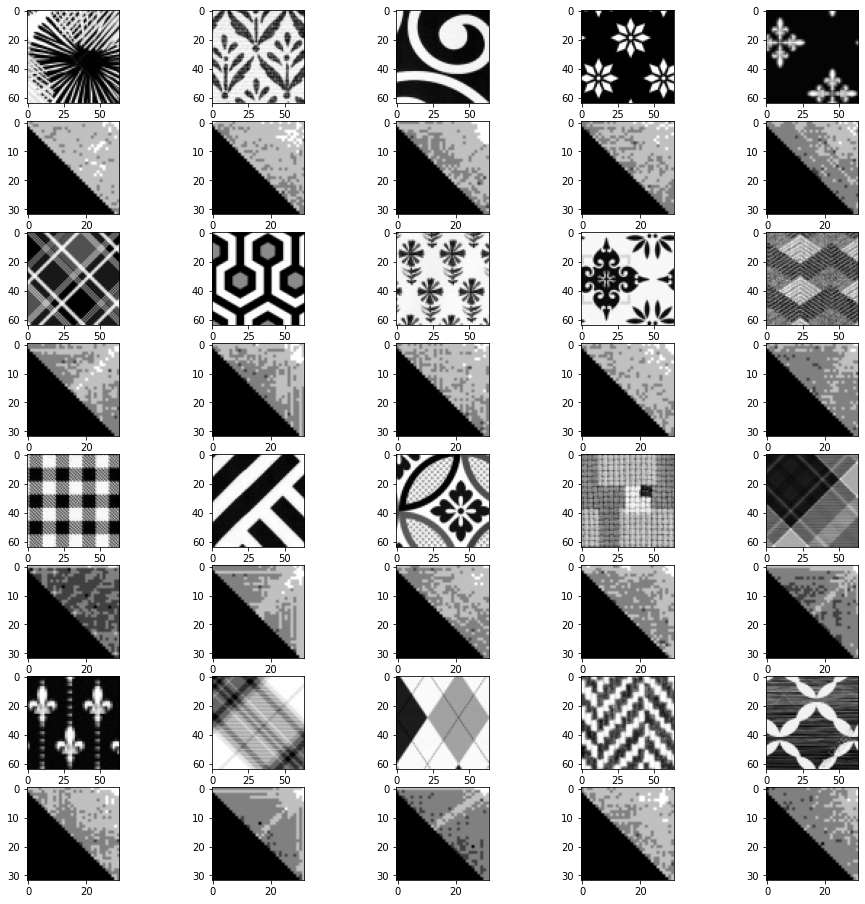

In [9]:
columns = (len(pattern_cropped) // 4) 
rows = 4 * 2
fig=plt.figure(figsize=(16, 16))
list_fft2 = []
for i, pat in enumerate(pattern_cropped):
    pic_fft2 = fft2(pat)
    line = i // columns
    fig.add_subplot(rows, columns, 2*columns*line + 1 + i % columns)
    plt.imshow(pat, cmap="gray")
#     plt.imshow(np.log10(abs(pic_fft2)), cmap="gray")
    fig.add_subplot(rows, columns, 2*columns*line + 1 + i % columns + columns)
#     pic_fft2 = fft2(pat - np.mean(pat))
#     plt.imshow(np.triu(pat[:32, 32:], -1), cmap="gray")
    plt.imshow(np.uint8(np.triu(np.log10(abs(pic_fft2))[:32, 32:], -1)), cmap="gray")
#     plt.imshow(np.uint8(np.log10(abs(pic_fft2))), cmap="gray")
    list_fft2.append(pic_fft2)
plt.show()

In [10]:
def find_sim(ev, patterns):
    euclidean_distances = []
    for idx, (pivot, dist) in enumerate(patterns):
        euclidean_distances.append(abs(np.linalg.norm(ev - ev @ pivot * pivot)))
    origin_dist = euclidean_distances[:]
    max_len = max(euclidean_distances)
    for idx in range(len(euclidean_distances)):
        euclidean_distances[idx] = abs(euclidean_distances[idx] - patterns[idx][1])
    return origin_dist, euclidean_distances

In [11]:
file_path_list = os.listdir("./fabrics/")
file_path_list.sort()
pattern_cropped = []
pattern_fft2s = []
for i,fp in enumerate(file_path_list):
    pic = cv2.imread("fabrics/" + fp, 0)
    h, w = pic.shape
    if h > 512:
        ratio = 512 / h
        pic = cv2.resize(pic, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)
    patterns = []
    for t in range(5):
        patterns.append(get_random_pattern(pic))
    pat_ffts = []
    for pat in patterns:
#         pat_ffts.append(abs(fft2(pat - np.mean(pat)))[:32,32:].flatten())
        pat_ffts.append(abs(fft2(pat - np.mean(pat)))[:32,32:][np.triu_indices(32)])
    pat_mean = sum(np.array(pat_ffts)) / len(pat_ffts)
    pat_mean = pat_mean / np.linalg.norm(pat_mean)
    pat_dists = []
    for t in range(5):
        pat_dists.append(np.linalg.norm(pat_ffts[t] - pat_ffts[t] @ pat_mean * pat_mean))
    pat_dist_mean = sum(pat_dists) / len(pat_dists)
    pattern_fft2s.append((pat_mean, pat_dist_mean))

In [12]:
file_path_list = os.listdir("./fabrics/")
file_path_list.sort()
matches = 0
for i,fp in enumerate(file_path_list):
    pic = cv2.imread("fabrics/" + fp, 0)
    h, w = pic.shape
    if h > 512:
        ratio = 512 / h
        pic = cv2.resize(pic, (0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)
    print("matches for {0:02d} : ".format(i))
    for t in range(5):
        pat = get_random_pattern(pic)
#         pat_fft = abs(fft2(pat - np.mean(pat)))[:32,32:].flatten()
        pat_fft = abs(fft2(pat - np.mean(pat)))[:32,32:][np.triu_indices(32)]
        result, delta = find_sim(pat_fft, pattern_fft2s)
        sorted_result = sorted(result)
        first_idx, second_idx = np.where(result == sorted_result[0])[0][0], np.where(result == sorted_result[1])[0][0]
        print("1st {} 2nd {}".format(first_idx, second_idx))
        print("dist  {} {}".format(result[first_idx], result[second_idx]))
        print("delta {} {}".format(delta[first_idx], delta[second_idx]))
#         real_result, diff_result = find_sim(pat_fft, pattern_fft2s)
#         sorted_result = sorted(diff_result)
#         first_idx, second_idx = np.where(diff_result == sorted_result[0])[0][0], np.where(diff_result == sorted_result[1])[0][0]
#         print("answer {} result {}".format(i, first_idx))
#         print("real_dist  {} {}".format(real_result[i], real_result[first_idx]))
#         print("diff_method {} {}".format(diff_result[i], diff_result[first_idx]))
#         print("mean  {} {}".format(pattern_fft2s[i][1], pattern_fft2s[first_idx][1]))

        if i == first_idx:
            matches += 1
        else:
            print("[[[========WRONG========]]]")
    print()
print("matches : {}%".format(100 * matches / (5 * len(file_path_list))))

matches for 00 : 
1st 0 2nd 13
dist  63258.78162161898 99798.07941736103
delta 14024.890636060692 69493.78820190593
1st 0 2nd 14
dist  52510.02418430631 70213.05650920623
delta 3276.1331987480226 45063.98715625397
1st 0 2nd 16
dist  59238.46647185799 74250.48137285716
delta 10004.575486299698 56981.417417036064
1st 0 2nd 3
dist  62668.305996058094 84643.48606475584
delta 13434.415010499804 59622.41149689014
1st 0 2nd 8
dist  63556.89910238415 78530.6693518773
delta 14323.008116825862 68156.67449516895

matches for 01 : 
1st 1 2nd 12
dist  53244.4160845308 88209.21991471354
delta 21785.937183600647 70504.77642277686
1st 1 2nd 12
dist  58475.89323368214 84946.07086937927
delta 27017.414332751985 67241.62737744261
1st 1 2nd 12
dist  56700.39944371057 98836.13860457289
delta 25241.92054278042 81131.69511263623
1st 1 2nd 12
dist  57648.466126016545 94779.30972201376
delta 26189.987225086392 77074.86623007708
1st 1 2nd 12
dist  44642.0194534795 91114.03335174495
delta 13183.540552549348 7340

In [13]:
for k, (i,j) in enumerate(pattern_fft2s):
    print(k, j)

0 49233.89098555829
1 31458.478900930153
2 51366.07866063264
3 25021.074567865697
4 15604.121958699858
5 25609.219232013602
6 29086.033423374938
7 31621.33936434016
8 10373.994856708345
9 11044.437022790342
10 6358.770813149759
11 54952.608725205435
12 17704.44349193667
13 30304.29121545511
14 25149.06935295226
15 29503.010725550022
16 17269.063955821093
17 20569.401239607396
18 35837.93165690124
19 10633.9862999126
